In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# ignore warnings 
pd.options.mode.chained_assignment = None # default='warn'

In [4]:
train_df = pd.read_csv('TMDB_train.csv')
eval_df = pd.read_csv('TMDB_evaluate.csv')
test_df = pd.read_csv('TMDB_test.csv')

### Data Preprocess

In [5]:
# replace missing value 0
train_df['budget'].replace(0, train_df['budget'].mean(), inplace = True)
train_df['revenue'].replace(0, train_df['revenue'].mean(), inplace = True)
train_df['popularity'].replace(0, train_df['popularity'].mean(), inplace = True)

eval_df['budget'].replace(0, eval_df['budget'].mean(), inplace = True)
eval_df['revenue'].replace(0, eval_df['revenue'].mean(), inplace = True)
eval_df['popularity'].replace(0, eval_df['popularity'].mean(), inplace = True)

test_df['budget'].replace(0, test_df['budget'].mean(), inplace = True)
test_df['revenue'].replace(0, test_df['revenue'].mean(), inplace = True)
test_df['popularity'].replace(0, test_df['popularity'].mean(), inplace = True)

C:\Users\user\AppData\Local\Temp\ipykernel_25644\1543050505.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['budget'].replace(0, train_df['budget'].mean(), inplace = True)
C:\Users\user\AppData\Local\Temp\ipykernel_25644\1543050505.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [6]:
train_vect = TfidfVectorizer()
train_tfidf = scipy.sparse.load_npz('train_concat_tfidf.npz')

train_lg_vect = train_vect.fit_transform(train_df['original_language'])
train_lg_column = train_vect.get_feature_names_out()
train_lg_df = pd.DataFrame(train_lg_vect.toarray(), columns = train_lg_column)

df_train_tfidf = pd.DataFrame(train_tfidf.toarray())
df_train_tfidf.columns = df_train_tfidf.columns.astype(str)
removed_train_df = train_df.drop(['title', 'overview', 'tagline', 'production_companies', 'original_language'], axis = 1)
final_train_df = pd.concat([df_train_tfidf, removed_train_df], axis = 1)

In [7]:
eval_vect = TfidfVectorizer()
eval_tfidf = scipy.sparse.load_npz('eval_concat_tfidf.npz')

eval_lg_vect = eval_vect.fit_transform(eval_df['original_language'])
eval_lg_column = eval_vect.get_feature_names_out()
eval_lg_df = pd.DataFrame(eval_lg_vect.toarray(), columns = eval_lg_column)

df_eval_tfidf = pd.DataFrame(eval_tfidf.toarray())
df_eval_tfidf.columns = df_eval_tfidf.columns.astype(str)
removed_eval_df = eval_df.drop(['title', 'overview', 'tagline', 'production_companies', 'original_language'], axis = 1)
final_eval_df = pd.concat([df_eval_tfidf, removed_eval_df], axis = 1)

In [8]:
test_vect = TfidfVectorizer()
test_lg_vect = test_vect.fit_transform(test_df['original_language'])
test_lg_column = test_vect.get_feature_names_out()
test_lg_df = pd.DataFrame(test_lg_vect.toarray(), columns = test_lg_column)

test_tfidf = scipy.sparse.load_npz('test_concat_tfidf.npz')
df_test_tfidf = pd.DataFrame(test_tfidf.toarray())
df_test_tfidf.columns = df_test_tfidf.columns.astype(str)
removed_test_df = test_df.drop(['title', 'overview', 'tagline', 'production_companies', 'original_language'], axis = 1)
final_test_df = pd.concat([df_test_tfidf, removed_test_df], axis = 1)

### Baseline Model Training: Logistic Regression

with genre columns

In [9]:
column_to_exclude = ['average_rate', 'rate_category']
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_y_pred = lgr.predict(X_eval)
lgr_Acc = accuracy_score(y_eval, lgr_y_pred)

print ("Accuracy of LGR with genre: ", round(lgr_Acc, 3))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LGR with genre:  0.272


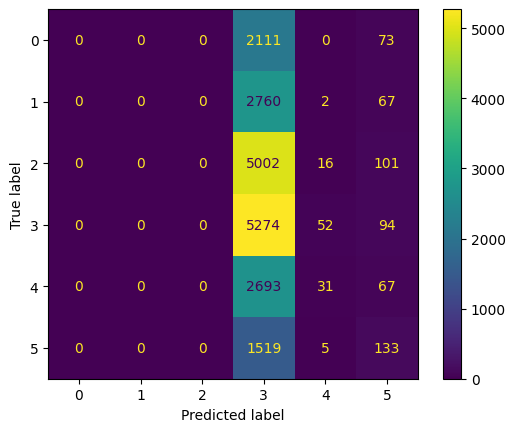

In [10]:
matrix = confusion_matrix(y_eval, lgr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = lgr.classes_)
disp.plot()
plt.show()

without genre columns

In [11]:
column_to_exclude = ['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 
                    'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 
                    'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 
                    'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'average_rate','rate_category']
                    
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_y_pred = lgr.predict(X_eval)
lgr_Acc = accuracy_score(y_eval, lgr_y_pred)

print ("Accuracy of LGR without genre: ", round(lgr_Acc, 3))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LGR without genre:  0.271


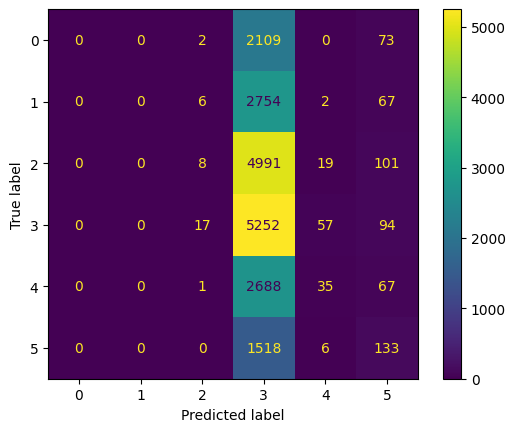

In [12]:
matrix = confusion_matrix(y_eval, lgr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = lgr.classes_)
disp.plot()
plt.show()

### Feature Engineering

In [13]:
final_train_df = final_train_df.drop(['budget'], axis = 1)
final_eval_df = final_eval_df.drop(['budget'], axis = 1)
final_test_df = final_test_df.drop(['budget'], axis = 1)

### Model Training: Decision Tree

with genre columns

In [14]:
column_to_exclude = ['average_rate', 'rate_category']
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_eval)
dt_Acc = accuracy_score(y_eval, dt_y_pred)

print ("Accuracy of DT with genre: ", round(dt_Acc, 3))
print()
print(classification_report(y_eval, dt_y_pred))


Accuracy of DT with genre:  0.655

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2184
           1       0.62      0.61      0.62      2829
           2       0.66      0.66      0.66      5119
           3       0.69      0.69      0.69      5420
           4       0.64      0.64      0.64      2791
           5       0.64      0.64      0.64      1657

    accuracy                           0.66     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.66      0.66      0.66     20000



predict unlabeled test dataset

In [15]:
X_test = final_test_df[final_test_df.columns.difference(column_to_exclude)]

test_predict = dt.predict(X_test)
test_predict_df = pd.DataFrame({'id': X_test['id'], 'rate_category': test_predict})

test_predict_df.to_csv('dt_prediction_with_genre.csv', index=False)

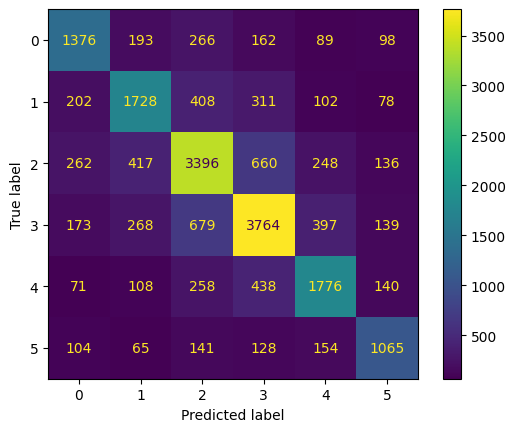

In [16]:
matrix = confusion_matrix(y_eval, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = dt.classes_)
disp.plot()
plt.show()

without genre columns

In [17]:
column_to_exclude = ['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 
                    'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 
                    'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 
                    'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'average_rate','rate_category']
                    
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_eval)
dt_Acc = accuracy_score(y_eval, dt_y_pred)

print ("Accuracy of DT without genre: ", round(dt_Acc, 3))
print()
print(classification_report(y_eval, dt_y_pred))

Accuracy of DT without genre:  0.648

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      2184
           1       0.62      0.62      0.62      2829
           2       0.65      0.66      0.65      5119
           3       0.67      0.68      0.68      5420
           4       0.63      0.62      0.63      2791
           5       0.64      0.64      0.64      1657

    accuracy                           0.65     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.65      0.65      0.65     20000



predict unlabeled test dataset

In [18]:
X_test = final_test_df[final_test_df.columns.difference(column_to_exclude)]

test_predict = dt.predict(X_test)
test_predict_df = pd.DataFrame({'id': X_test['id'], 'rate_category': test_predict})

test_predict_df.to_csv('dt_prediction_without_genre.csv', index=False)

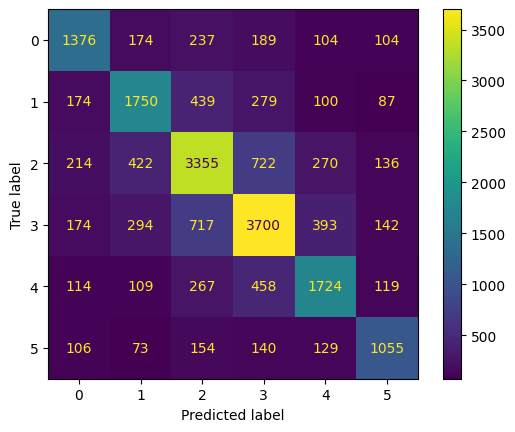

In [19]:
matrix = confusion_matrix(y_eval, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = dt.classes_)
disp.plot()
plt.show()

### Model Training: Random Forest

with genre columns

In [27]:
column_to_exclude = ['average_rate', 'rate_category']
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_y_pred = rfc.predict(X_eval)
rfc_Acc = accuracy_score(y_eval, rfc_y_pred)

print ("Accuracy of RFC with genre: ", round(rfc_Acc, 3))
print()
print(classification_report(y_eval, rfc_y_pred))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy of RFC with genre:  0.688

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      2184
           1       0.89      0.54      0.68      2829
           2       0.61      0.74      0.67      5119
           3       0.63      0.81      0.71      5420
           4       0.87      0.56      0.68      2791
           5       0.74      0.67      0.70      1657

    accuracy                           0.69     20000
   macro avg       0.76      0.66      0.69     20000
weighted avg       0.72      0.69      0.69     20000



predict unlabeled test dataset

In [28]:
X_test = final_test_df[final_test_df.columns.difference(column_to_exclude)]

test_predict = rfc.predict(X_test)
test_predict_df = pd.DataFrame({'id': X_test['id'], 'rate_category': test_predict})

test_predict_df.to_csv('rfc_prediction_with_genre.csv', index=False)

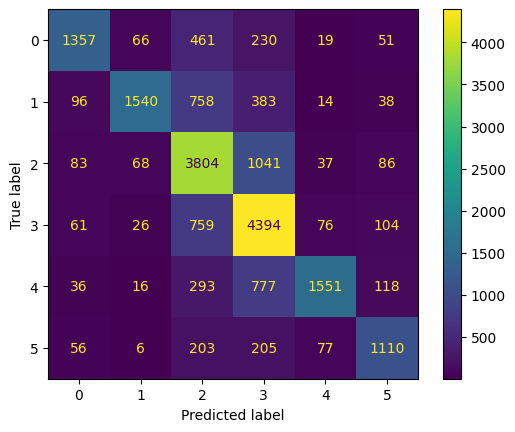

In [29]:
matrix = confusion_matrix(y_eval, rfc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = rfc.classes_)
disp.plot()
plt.show()

without genre columns

In [30]:
column_to_exclude = ['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 
                    'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 
                    'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 
                    'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'average_rate','rate_category']
                    
X_train = final_train_df[final_train_df.columns.difference(column_to_exclude)]
y_train = final_train_df[['rate_category']]

X_eval = final_eval_df[final_eval_df.columns.difference(column_to_exclude)]
y_eval = final_eval_df[['rate_category']]

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_y_pred = rfc.predict(X_eval)
rfc_Acc = accuracy_score(y_eval, rfc_y_pred)

print ("Accuracy of RFC without genre: ", round(rfc_Acc, 3))
print()
print(classification_report(y_eval, rfc_y_pred))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy of RFC without genre:  0.673

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      2184
           1       0.93      0.53      0.67      2829
           2       0.59      0.73      0.65      5119
           3       0.59      0.81      0.68      5420
           4       0.89      0.55      0.68      2791
           5       0.78      0.64      0.70      1657

    accuracy                           0.67     20000
   macro avg       0.77      0.64      0.68     20000
weighted avg       0.72      0.67      0.67     20000



predict unlabeled test dataset

In [31]:
X_test = final_test_df[final_test_df.columns.difference(column_to_exclude)]

test_predict = rfc.predict(X_test)
test_predict_df = pd.DataFrame({'id': X_test['id'], 'rate_category': test_predict})

test_predict_df.to_csv('rfc_prediction_without_genre.csv', index=False)

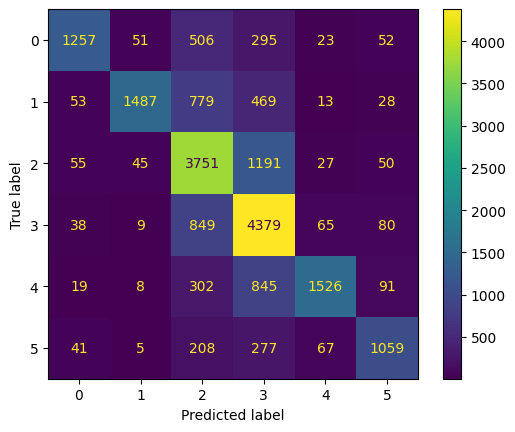

In [32]:
matrix = confusion_matrix(y_eval, rfc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = rfc.classes_)
disp.plot()
plt.show()